In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [14]:
train_dir = "../input/covid/train/"
valid_dir = "../input/covid/test/"

img_width, img_height = 224, 224 

In [15]:
conv_base = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, 3),
)


conv_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

from PIL import Image
import os, numpy as np
folder = '../input/covid/test/covid/'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

ims = [read(os.path.join(folder, filename)) for filename in os.listdir(folder)]
im_array = np.array(ims,dtype='object')

folder = '../input/covid/test/noncovid/'

read1 = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

ims1 = [read(os.path.join(folder, filename)) for filename in os.listdir(folder)]
im_array1 = np.array(ims,dtype='object')

In [16]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024)) # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,2))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
 
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 1616) 
validation_features, validation_labels = extract_features(valid_dir, 392)


Found 1616 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [17]:
train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [18]:
epochs = 150

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7, 7, 1024)))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  


from keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])


history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Epoch 1/150
51/51 [==============================] - 1s 12ms/step - loss: 0.3922 - acc: 0.8162 - val_loss: 0.1290 - val_acc: 0.9745

Epoch 00001: val_loss improved from inf to 0.12900, saving model to model-001-0.920792-0.974490.h5
Epoch 2/150
51/51 [==============================] - 0s 6ms/step - loss: 0.0695 - acc: 0.9846 - val_loss: 0.0891 - val_acc: 0.9821

Epoch 00002: val_loss improved from 0.12900 to 0.08905, saving model to model-002-0.987624-0.982143.h5
Epoch 3/150
51/51 [==============================] - 0s 6ms/step - loss: 0.0476 - acc: 0.9902 - val_loss: 0.0730 - val_acc: 0.9821

Epoch 00003: val_loss improved from 0.08905 to 0.07304, saving model to model-003-0.990718-0.982143.h5
Epoch 4/150
51/51 [==============================] - 0s 6ms/step - loss: 0.0360 - acc: 0.9896 - val_loss: 0.0513 - val_acc: 0.9949

Epoch 00004: val_loss improved from 0.07304 to 0.05129, saving model to model-004-0.992574-0.994898.h5
Epoch 5/150
51/51 [==============================] - 0s 6ms/ste

51/51 [==============================] - 0s 7ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9923

Epoch 00037: val_loss improved from 0.01436 to 0.01424, saving model to model-037-1.000000-0.992347.h5
Epoch 38/150
51/51 [==============================] - 0s 7ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 0.9898

Epoch 00038: val_loss did not improve from 0.01424
Epoch 39/150
51/51 [==============================] - 0s 7ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9898

Epoch 00039: val_loss did not improve from 0.01424
Epoch 40/150
51/51 [==============================] - 0s 7ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9898

Epoch 00040: val_loss did not improve from 0.01424
Epoch 41/150
51/51 [==============================] - 0s 7ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9949

Epoch 00041: val_loss improved from 0.01424 to 0.01393, saving model to model-041-1.000000-0

51/51 [==============================] - 0s 8ms/step - loss: 4.4563e-04 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 0.9923

Epoch 00078: val_loss did not improve from 0.01300
Epoch 79/150
51/51 [==============================] - 0s 9ms/step - loss: 4.1323e-04 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9898

Epoch 00079: val_loss did not improve from 0.01300
Epoch 80/150
51/51 [==============================] - 0s 8ms/step - loss: 4.1665e-04 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9923

Epoch 00080: val_loss did not improve from 0.01300
Epoch 81/150
51/51 [==============================] - 0s 7ms/step - loss: 4.7779e-04 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9898

Epoch 00081: val_loss did not improve from 0.01300
Epoch 82/150
51/51 [==============================] - 0s 7ms/step - loss: 3.8017e-04 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9923

Epoch 00082: val_loss did not improve from 0.01300
Epoch 83/150
51/51 [==============================] - 0s 7ms/step - loss:


Epoch 00121: val_loss did not improve from 0.01300
Epoch 122/150
51/51 [==============================] - 0s 7ms/step - loss: 1.1571e-04 - acc: 1.0000 - val_loss: 0.0165 - val_acc: 0.9898

Epoch 00122: val_loss did not improve from 0.01300
Epoch 123/150
51/51 [==============================] - 0s 7ms/step - loss: 9.6038e-05 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9898

Epoch 00123: val_loss did not improve from 0.01300
Epoch 124/150
51/51 [==============================] - 0s 7ms/step - loss: 1.2093e-04 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 0.9898

Epoch 00124: val_loss did not improve from 0.01300
Epoch 125/150
51/51 [==============================] - 0s 7ms/step - loss: 1.1637e-04 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9898

Epoch 00125: val_loss did not improve from 0.01300
Epoch 126/150
51/51 [==============================] - 0s 6ms/step - loss: 1.2042e-04 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 0.9898

Epoch 00126: val_loss did not improve from 0.01300
Epo

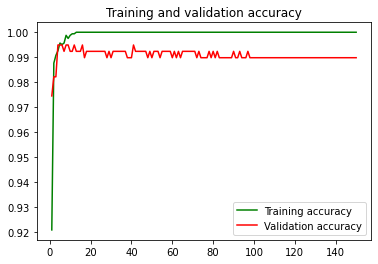

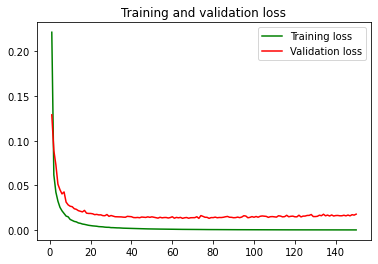

In [20]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
from keras.preprocessing import image
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  
    img_tensor /= 255.  
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*1024))
        
    classes = ["covid","noncovid"]
    print("I see..."+str(classes[np.argmax(np.array(prediction[0]))]))

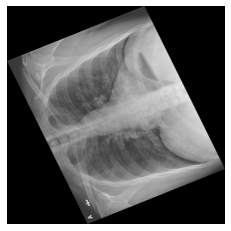

I see...covid


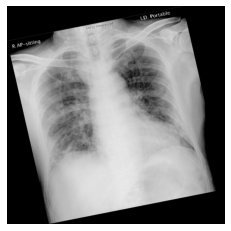

I see...covid


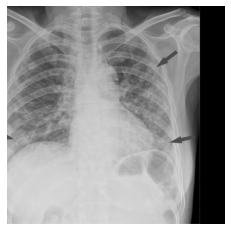

I see...covid


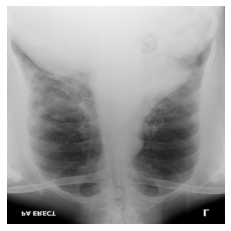

I see...covid


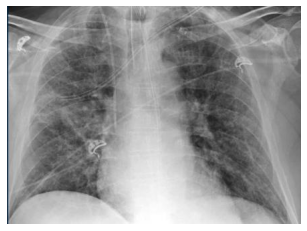

I see...covid


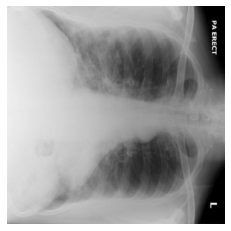

I see...covid


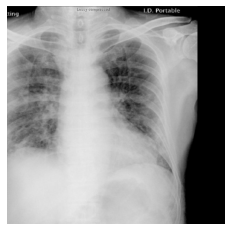

I see...covid


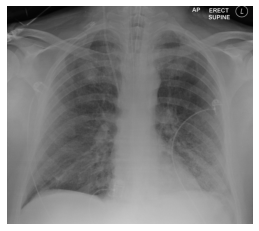

I see...covid


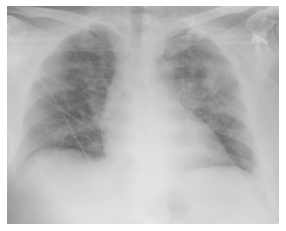

I see...covid


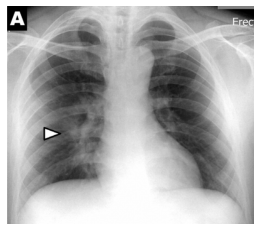

I see...covid


In [28]:
pred_dir = "../input/covid/test/covid/"
import random
pred_files = random.sample(os.listdir(pred_dir),10)
for f in pred_files:
    prediction(pred_dir+f)



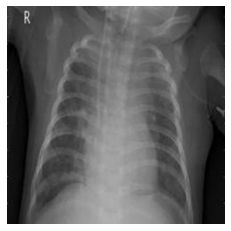

I see...noncovid


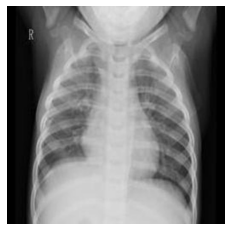

I see...noncovid


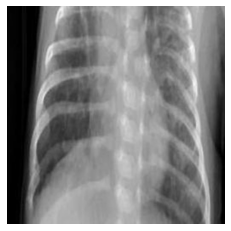

I see...noncovid


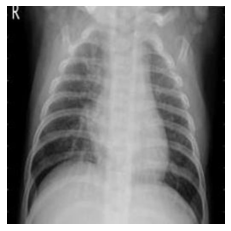

I see...noncovid


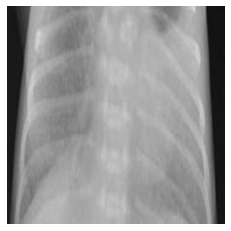

I see...noncovid


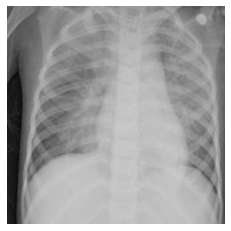

I see...noncovid


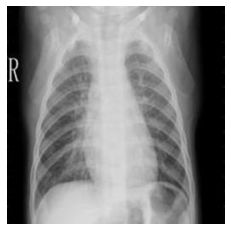

I see...noncovid


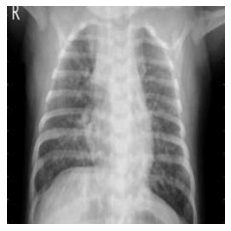

I see...noncovid


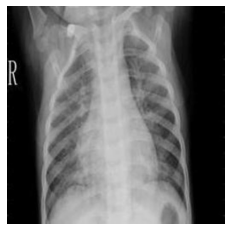

I see...noncovid


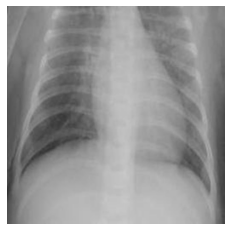

I see...noncovid


In [29]:
pred_dir = "../input/covid/test/noncovid/"
import random
pred_files = random.sample(os.listdir(pred_dir),10)
for f in pred_files:
    prediction(pred_dir+f)